# Root Insurance Challenge 



## Analysis

In [1]:
# Import packages

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from colorama import Fore, Back, Style 

from IPython.display import clear_output

In [2]:
#Importing data

acme = pd.read_excel("Acme.xlsx")
#acme.head()

## Saeed New Analysis

Now, I convert all 4 characteristic variables to dummy. Then a categorical indicator variable with $2^4=16$ different values will be created from these 4 dummy variables. The new variable is named IMVD_Indicator_1_16 which accounts for all different combinations of the four characteristics variables. IMVD stands for (Insured-Mearried-Vehicles2-Drivers2) and it's a four digit base-2 number, where each 0 or 1 in any digit shows the value of the corresponding variable. This variable will simplify the analysis.

In [3]:
#Transforming data set to make analyses easier
acmeS = pd.DataFrame(acme[['click','policies sold','cost','rank']])
acmeS['insured'] = (acme['currently_insured']=='Y')*1
acmeS['married'] = (acme['marital_status']=='M')*1
acmeS['vehicles'] = (acme['number_of_vehicles']==2)*1
acmeS['drivers'] = (acme['number_of_drivers']==2)*1
#below I create a categorical variable for all possible customer characteristics
acmeS['IMVD_Indicator_1_16'] = acmeS['insured']*8 + acmeS['married']*4 + acmeS['vehicles']*2 + acmeS['drivers']*1 + 1
acmeS.head()

,click,policies sold,cost,rank,insured,married,vehicles,drivers,IMVD_Indicator_1_16
0,1,1,10,1,0,1,0,0,5
1,0,0,10,4,0,1,1,0,7
2,0,0,10,2,0,0,0,0,1
3,0,0,10,5,1,1,1,0,15
4,0,0,10,4,1,0,1,1,12


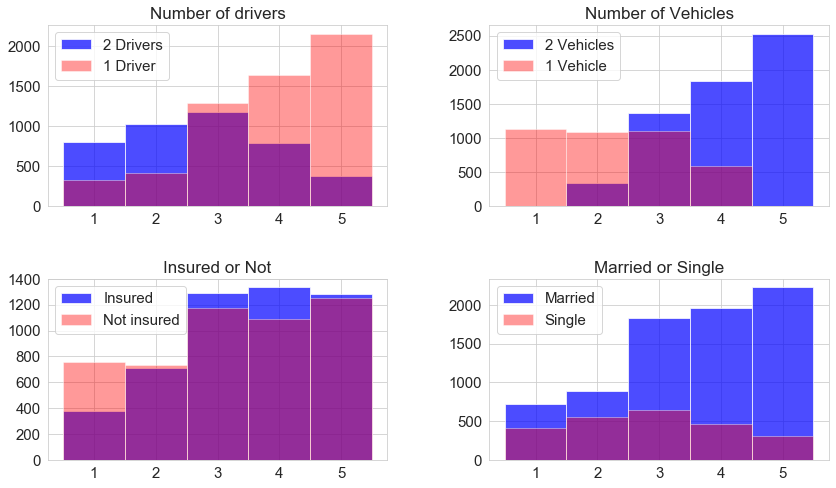

In [4]:
#Let's plot histograms for all 4 dummy variables and see how ranks are different

fig, ax2 = plt.subplots(2,2, figsize=(14, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace= .3)
ax2 = ax2.ravel()


ax2[1].hist(acmeS['rank'].loc[acmeS['vehicles'] == 1],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.7,color='b',label='2 Vehicles')
ax2[1].hist(acmeS['rank'].loc[acmeS['vehicles'] == 0],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.4,color='r',label='1 Vehicle')
ax2[1].set_title('Number of Vehicles', fontsize=17)
ax2[1].legend(fontsize=15)
for tick in ax2[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
ax2[2].hist(acmeS['rank'].loc[acmeS['insured'] == 1],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.7,color='b',label='Insured')
ax2[2].hist(acmeS['rank'].loc[acmeS['insured'] == 0],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.4,color='r',label='Not insured')
ax2[2].set_title('Insured or Not', fontsize=17)
ax2[2].legend(fontsize=15)
for tick in ax2[2].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2[2].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
ax2[3].hist(acmeS['rank'].loc[acmeS['married'] == 1],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.7,color='b',label='Married')
ax2[3].hist(acmeS['rank'].loc[acmeS['married'] == 0],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.4,color='r',label='Single')
ax2[3].set_title('Married or Single', fontsize=17)
ax2[3].legend(fontsize=15)
for tick in ax2[3].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2[3].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
ax2[0].hist(acmeS['rank'].loc[acmeS['drivers'] == 1],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.7,color='b',label='2 Drivers')
ax2[0].hist(acmeS['rank'].loc[acmeS['drivers'] == 0],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.4,color='r',label='1 Driver')
ax2[0].set_title('Number of drivers', fontsize=17)
ax2[0].legend(fontsize=15)
for tick in ax2[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    

## Everything makes sense EXCEPT the histogram for Insured vs. Not Insured.

If we bid $10 for each click, we can't rank #1 more for those without insurance than those with insurance, unless the competitors bid higher for less profitable cases. We also know the fact that those without insurance have greater likelihood of buying if they click (48\%) than those with insurance (30\%).

## Loosing a large segment of the market!

The histogram for the number of vehicles, combined with information on P(Click|Rank) and P(Sale|Click), shows that under current bidding strategy we lose most of the potential customers who own 2 vehicles. Apparantly opponents value these type of customers more and they bid accordingly. We will assume double value for 2 vehicle owners than 1 vehicle owners.

<Figure size 936x936 with 0 Axes>

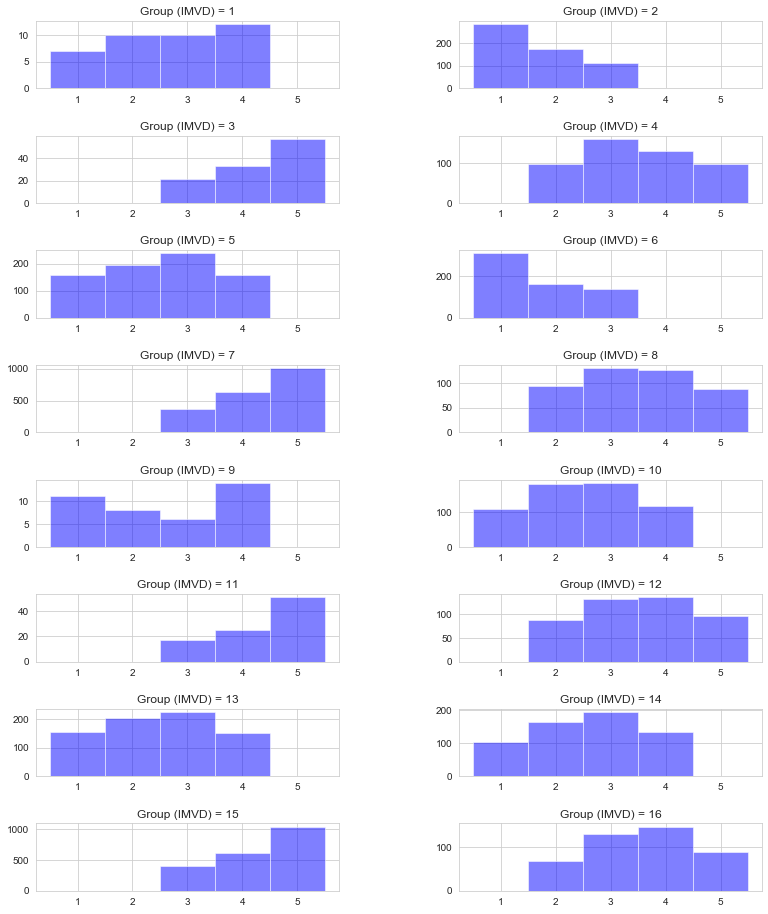

In [5]:
#Plotting histograms for all 16 different (IMVD) groups
plt.figure(figsize=(13,13))
fig, ax0 = plt.subplots(8,2, figsize=(13, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .7, wspace= .4)
ax0 = ax0.ravel()

for jj in range(1,17):
    ax0[jj-1].hist(acmeS['rank'].loc[acmeS['IMVD_Indicator_1_16'] == jj],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.5,color='b')
    ax0[jj-1].set_title('Group (IMVD) = ' +str(jj))

### Main characteristics
Comparing the above histograms show that Number of vehicles and number of drivers are important for opponents. The competitors generally value 2 vehicle owners high, and value the 2-driver customers less (higher risk for this type). We can see the irregularity about currently insured vs. not insured customers here too. The marital status seems to play no significant role (For example note that there's no difference between IMVD=1 and IMVD=5 or similarly between IMVD=2 and IMVD=6, and so on.)

# Overcoming Data Shortcomings
The fact that we have no variation in our bids data (all bids constant at $10) as well as no observations for competitors' bids makes it difficult to make proper analysis on optimal bids. However, it is possible to infer the behavior of competitors and their bids given the rich data on ranks.

## Creating Competitors' Bid data

Here, I'm trying to infer competitors' bids using the information on rank. I'll simulate the competitors' behaviour and create the hypothetical bid data.

As shown above we have 16 different combination of the binary variables (shown by variable IMVD_Indicator_1_16) that jointly with bid value, determine our rank. Within each of these 16 cases we have variability in ranks shown by above histograms. The analysis is based on three main assumptions.

### Assumption1:
There are many competitors who place bids, and it creates variability in the bidding cost within each of the 16 different charachteristic groups.

### Assumption2:
The distribution of top 5 bidders prices (including ours, because all observations are for cases with Acme in top 5) is normally distributed with mean $\mu$ and variance $\sigma^2$.

### Assumption3:
$0<\sigma^2<<\infty$. The variance of the distribution isn't too large. This means that the probability of opponents placing extremely high/low bids is very small. This is reasonable given the fact that all the participants are trying to maximize gains while keeping the costs as low as they can.

### Goal:
The goal is to replicate the rank histograms shown above using the inferred bids by opponents. I will try to estimate $\mu$ and $\sigma^2$ in a way to minimize the distance between observed and estimated rank histograms. A sort of calibration exercise. We define the following error function and will try to find distributional parametrs that minimize it.

In [6]:
#Trying to minimize hist error

def get_errs(meanCoeff , var , df , IMVD):
    
    for iname in range(1,5):
        name = "Comp" + str(iname) #Competitors' bid
        df[name] = np.random.randint(5,16,len(df['rank']))
        ind1 = IMVD
        xmean = 10 + meanCoeff*(np.mean(df['rank'].loc[df['IMVD_Indicator_1_16']==ind1]) - 3)
        df[name].loc[df['IMVD_Indicator_1_16']==ind1] = np.random.normal(xmean,var,len(df[name].loc[df['IMVD_Indicator_1_16']==ind1]))
        #acmeS[name].loc[acmeS['IMVD_Indicator_1_16']==ind1] = np.random.randint(xmin,xmax,len(acmeS[name].loc[acmeS['IMVD_Indicator_1_16']==ind1]))
    
    df['MyRanking'] = np.random.randint(50,60,len(acmeS['rank']))
    r1 = (df['cost'] < df['Comp1'])*1
    r2 = (df['cost'] < df['Comp2'])*1
    r3 = (df['cost'] < df['Comp3'])*1
    r4 = (df['cost'] < df['Comp4'])*1
    acmeS['MyRanking'] = r1+r2+r3+r4+1
    #acmeS['RankDiff'] = acmeS['MyRanking'] - acmeS['rank']
    errs = [0,0,0,0,0]
    for bin1 in range(1,6):
        ind1 = IMVD
        g1 = len(df['MyRanking'].loc[df['IMVD_Indicator_1_16']==ind1].loc[df['MyRanking']==bin1])
        t1 = len(df['rank'].loc[df['IMVD_Indicator_1_16']==ind1].loc[df['rank']==bin1])
        s1 = np.abs(g1-t1)
        errs[bin1-1] = errs[bin1-1] + s1
        
    return errs

## Calibration
Now we estimate the distributional parameters using the error function defined above. A grid search method is used here, which can be made more efficient if we introduce other search methods like Bisection, Broyden's, etc.

Progress :  100.0 %


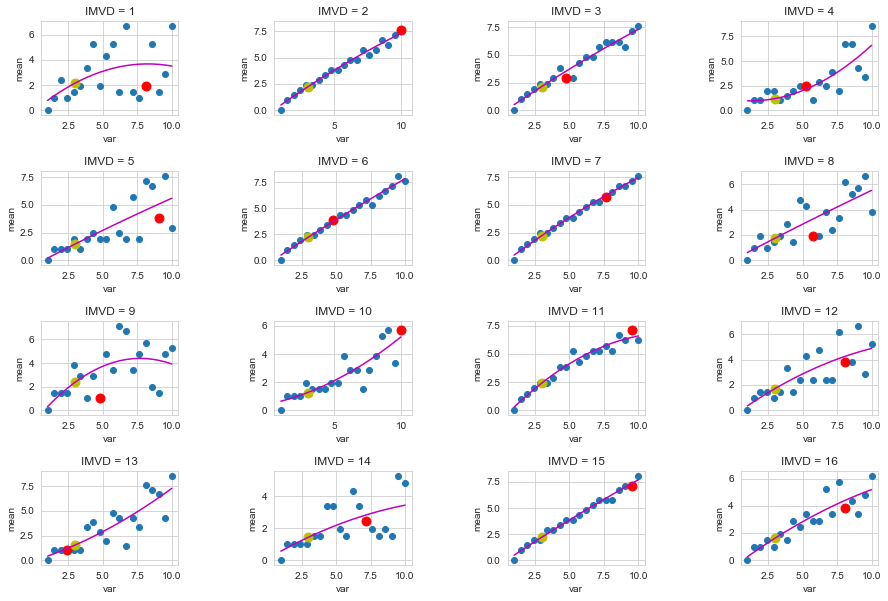

In [7]:
meanCt = 20
varCt = 20
meanOpt_1 = np.zeros(16)
varOpt_1 = np.zeros(16)
meanOpt_preset = np.zeros(16) #identify either var or mean and find the other one accordingly
varOpt_preset = np.zeros(16)
meanGrid = np.linspace(1,10,meanCt)
varGrid = np.linspace(1,10,varCt)
errsum = np.random.randint(1,5,[meanCt,varCt])
err_tot = np.zeros([16,1])

fig, ax = plt.subplots(4,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace= .7)
ax = ax.ravel()
    
for ind01 in range(1,17):
    
    dftemp = acmeS
    mc_i = -1
    for mc in meanGrid: #meanCoeffs
        
        clear_output(wait=True)
        print('Progress : ' , np.round(((ind01-1)/16 + (mc_i + 2)/meanCt/16)*100 , 0) , '%')
        
        mc_i = mc_i + 1
        vc_i = -1
        for vc in varGrid: #variances
            vc_i = vc_i + 1
            q = np.sum(get_errs(mc,vc,dftemp,ind01))
            errsum[mc_i,vc_i] = q
            #print(q)
    
    meanOpt_arr = np.zeros([len(varGrid) , 1])
    for ii in range(1,len(varGrid)):
        index_min_arr = np.where(errsum[:,ii] == errsum[:,ii].min())
        #print(ii , index_min_arr , index_min_arr[0][0])
        meanOpt_arr[ii] = meanGrid[index_min_arr[0][0]]    
        
    ax[ind01-1].scatter(varGrid,meanOpt_arr)
    ax[ind01-1].set_xlabel('var')
    ax[ind01-1].set_ylabel('mean')
    ax[ind01-1].set_title('IMVD = ' + str(ind01))
    
    err_tot[ind01-1] = errsum.min()
    ## set mean and var based on whatever min value of err is
    index_min = np.where(errsum == errsum.min())
    meanOpt_1[ind01-1] = meanGrid[index_min[0][0]]
    varOpt_1[ind01-1] = varGrid[index_min[1][0]]
    
    #Pre-identify one variable: say set var = 3 or 4, etc. then find the corresponding mean that minimizes error

    #To minimize the role of random errors, I set the variance and find the error minimizing mean using a dgree 2 polynomial regression line.
    var = 3
    varOpt_preset[ind01-1] = var
    x = varGrid
    y = meanOpt_arr
    x = x[:, np.newaxis]
    #y = y[:, np.newaxis]

    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    
    meanOpt_preset[ind01-1] = model.predict([[1,var,var**2]])
    
    ax[ind01-1].plot(x, y_poly_pred, color='m')
    ax[ind01-1].scatter(varOpt_1[ind01-1], meanOpt_1[ind01-1], color='r' , s=80)
    ax[ind01-1].scatter(varOpt_preset[ind01-1], meanOpt_preset[ind01-1], color='y' , s=80)
    

## Identification
The above scatter plots show the relationship between error-minimizing mean and variance. As we can see the relationship is linear, but there are errors in some cases due to random nature of the process, as well as low number of observations in some IMVD groups. This linear relationship suggests that we can pre-identify one of these parameters and then find the other one accordingly. Here we choose to pre-identify variance, and by our third assumption above, we set the variance equal to 4. It should be noted that our results are robust to the choice of opponents' bid variance and only change slightly when we change variance.

In [8]:
#Set the optimal mean and variance

meanOpt = meanOpt_preset
varOpt = varOpt_preset
# uncomment the following two lines to use random values (Not recommended)
#meanOpt = meanOpt_1
#varOpt = varOpt_1

## Generating competitors' bids
Now using the distributional parameters estimated above, we generate the bidding behavior for competitors, and will use the created opponent bid data to re-create the ranks for all 16 characteristics groups.

In [9]:
for iname in range(1,5):
    name = "Comp" + str(iname) #Competitors' bid
    acmeS[name] = np.random.randint(5,16,len(acmeS['rank']))
    for ind1 in range(1,17):
        meanCoeff = meanOpt[ind1-1]
        var = varOpt[ind1-1]
        xmean = 10 + meanCoeff*(np.mean(acmeS['rank'].loc[acmeS['IMVD_Indicator_1_16']==ind1]) - 3)
        acmeS[name].loc[acmeS['IMVD_Indicator_1_16']==ind1] = np.random.normal(xmean,var,len(acmeS[name].loc[acmeS['IMVD_Indicator_1_16']==ind1]))


C:\Users\shakerakhtekhane.1\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
acmeS['MyRanking'] = np.random.randint(5,16,len(acmeS['rank']))
r1 = (acmeS['cost'] < acmeS['Comp1'])*1
r2 = (acmeS['cost'] < acmeS['Comp2'])*1
r3 = (acmeS['cost'] < acmeS['Comp3'])*1
r4 = (acmeS['cost'] < acmeS['Comp4'])*1
acmeS['MyRanking'] = r1+r2+r3+r4+1
#acmeS.sample(5)

Overall accuracy of estimated distributions is : 0.8864 %


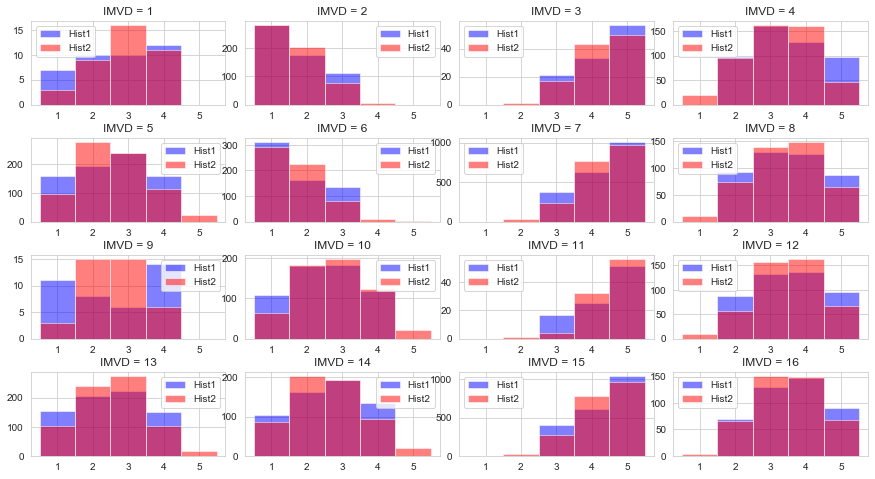

In [11]:
#Now plotting rank histograms for different groups

fig, ax2 = plt.subplots(4,4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace= .1)
ax2 = ax2.ravel()

for jj in range(1,17):
    ax2[jj-1].hist(acmeS['rank'].loc[acmeS['IMVD_Indicator_1_16'] == jj],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.5,color='b',label='Hist1')
    ax2[jj-1].hist(acmeS['MyRanking'].loc[acmeS['IMVD_Indicator_1_16'] == jj],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.5,color='r',label='Hist2')
    ax2[jj-1].set_title('IMVD = ' + str(jj))
    ax2[jj-1].legend()

err01 = 0
for ii in range(1,6):
    err01 = err01 + np.abs(np.sum(acmeS['MyRanking'].loc[acmeS['MyRanking']==ii]) - np.sum(acmeS['rank'].loc[acmeS['rank']==ii]))/ii
print('Overall accuracy of estimated distributions is :' , (10000-err01)/10000 ,'%')

## Loved it! Pretty Close Match!
Considering all the limitations, I believe we've done a pretty good job matching the distribution of the ranks. As of now, our matching accuracy is about 90%. And no need to mention that, we could also improve upon this if we used other more complicated techniques. But for simplicity and tractability of the analysis I decided not to go too far in this direction.

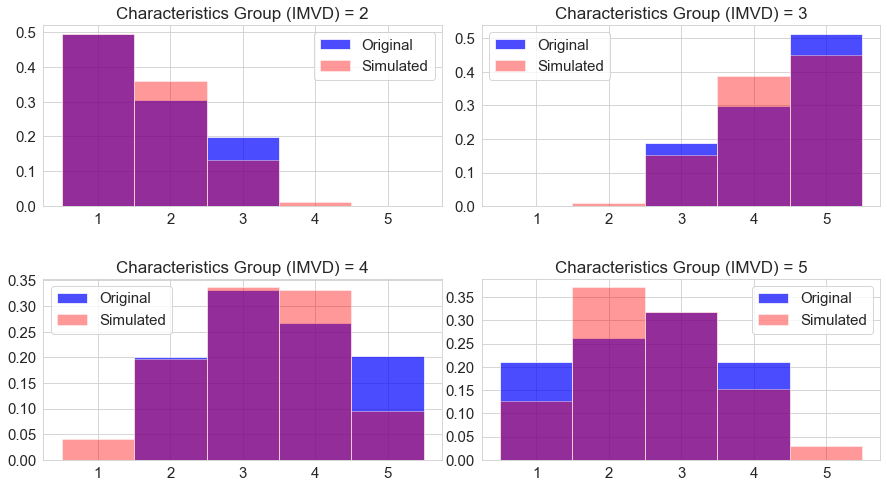

In [12]:
# just picked four different graphs for presentation

fig, ax2 = plt.subplots(2,2, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace= .1)
ax2 = ax2.ravel()

ii=0
for jj in [2,3,4,5]:
    #plt.subplot(8,2,jj)
    ax2[ii].hist(acmeS['rank'].loc[acmeS['IMVD_Indicator_1_16'] == jj],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.7,color='b',label='Original',density=True)
    ax2[ii].hist(acmeS['MyRanking'].loc[acmeS['IMVD_Indicator_1_16'] == jj],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.4,color='r',label='Simulated',density=True)
    ax2[ii].set_title('Characteristics Group (IMVD) = ' + str(ii+2), fontsize=17)
    ax2[ii].legend(fontsize=15)
    for tick in ax2[ii].xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    for tick in ax2[ii].yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    ii = ii + 1

(array([ 968., 1713., 2231., 2722., 2366.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 5 Patch objects>)

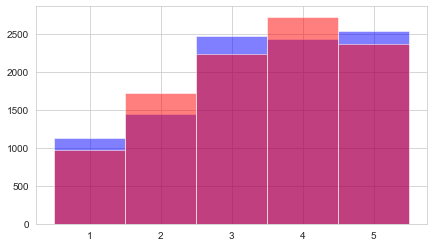

In [13]:
# Overall distribution match
plt.figure(figsize=(7,4))
plt.hist(acmeS['rank'],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.5,color='b')
plt.hist(acmeS['MyRanking'],bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],alpha=0.5,color='r')

## Optimization
Given the simulated opponent bid data, I will find the optimal bid for each of the 16 groups (IMVD charachteristic groups).

Every new bid for any group will result in a new rank distribution (histogram). Then using the new distribution I will check how much the chance of being rank 1 increases (or maybe how much the average rank goes up) and also check what is that group's purchase probability conditional on click.
### Optimization problem
$\text{For (IMVD)} \in \{1,2,...,16\}$ we solve the following:
$$\max_{bid} \frac{E_{rank} \left[ P(buy | click) | bid \right]}{bid} \\
\text{subject to} \\
\frac{E_{rank} \left[ P(buy | click) | bid \right]}{bid} > 0.004
$$

which is the same as following:

$$\max_{bid} \frac{\sum_{i=1}^{5} P(buy | click_i) \times P(click | rank_i) \times P(rank_i | bid)}{bid} \\
\text{subject to} \\
\frac{\sum_{i=1}^{5} P(buy | click_i) \times P(click | rank_i) \times P(rank_i | bid)}{bid} > 0.004
$$

That means, the bid should be chosen in a way that it maximizes probability of click and that leading to a purchase for every group.
Note that using the stylized facts stated earlier, we can see that $P(buy | click_i)=P(buy | click)$, i.e. it does not depend on rank (it only depends on IMVD group). That is, the probability of purchase conditional on click is similar for different ranks. Similarly, $P_{IMVD}(click | rank_i)=P(click | rank_i)$, i.e. it does not depend on group and it only depends on rank.
### Exception for potential customers with two vehicles
No need to mention that the optimization problem above is suited for those with only one vehicle. For those with two vehicles we only need to adjust the constraint, and assuming double the value of a single vehicle purchase we get the following optimization problem:

$\text{For (IMVD)} \in \{1,2,...,16\}$ where $V=1$:
$$\max_{bid} \frac{\sum_{i=1}^{5} P(buy | click_i) \times P(click | rank_i) \times P(rank_i | bid)}{bid} \\
\text{subject to} \\
\frac{\sum_{i=1}^{5} P(buy | click_i) \times P(click | rank_i) \times P(rank_i | bid)}{bid} > 0.002
$$

In [14]:
#Let's get the pre-defined probabilities first: P(buy|click_i) and P(click|rank_i)
Pclk_rnk=np.zeros([5]) #P(click|rank_i)
Pbuy_clk=np.zeros([16]) #P(buy|click_i)
rnks = np.zeros([16,5]) #freq(rank_i|price)
rnks_prob = np.zeros([16,5]) #P(rank_i|price)
clks = np.zeros([5]) #number of clicks for each rank and group
buys = np.zeros([16]) #number of purchases conditional on click for each rank and group
rel_rnks = np.zeros([16,5]) #A dummy variable taking zero if number of observations for...
#any given group-rank combination is less than a threshold (rel_size)
targets00 = np.zeros([16,5]) #this gives the expression inside Sigma in optimization formula
rel_size = 15
for IMVD in range(1,17):
    for rnk in range(1,6):
        rnks[IMVD-1][rnk-1] = len(acmeS['rank'].loc[acmeS['rank'] == rnk].loc[acmeS['IMVD_Indicator_1_16'] == IMVD])
        rnks_prob[IMVD-1][rnk-1] = rnks[IMVD-1][rnk-1] / len(acmeS['rank'].loc[acmeS['IMVD_Indicator_1_16'] == IMVD])
        
for rnk in range(1,6):
    clks[rnk-1] = len(acmeS['click'].loc[acmeS['click'] == 1].loc[acmeS['rank'] == rnk])
    Pclk_rnk[rnk-1] = np.mean(acmeS['click'].loc[acmeS['rank'] == rnk])
    #buys[rnk-1] = len(acmeS['policies sold'].loc[acmeS['policies sold'] == 1].loc[acmeS['rank'] == rnk].loc[acmeS['click'] == 1])
    #Pbuy_clk[rnk-1] = np.mean(acmeS['policies sold'].loc[acmeS['rank'] == rnk].loc[acmeS['click'] == 1])
    for IMVD in range(1,17):
        buys[IMVD-1] = len(acmeS['policies sold'].loc[acmeS['policies sold'] == 1].loc[acmeS['IMVD_Indicator_1_16'] == IMVD].loc[acmeS['click'] == 1])
        Pbuy_clk[IMVD-1] = np.mean(acmeS['policies sold'].loc[acmeS['IMVD_Indicator_1_16'] == IMVD].loc[acmeS['click'] == 1])
        #if IMVD in [3,4,7,8,11,12,15,16]:
        #    Pbuy_clk[IMVD-1] = Pbuy_clk[IMVD-1]*2
        targets00[IMVD-1][rnk-1] = rnks_prob[IMVD-1][rnk-1]*Pclk_rnk[rnk-1]*Pbuy_clk[IMVD-1]
nan_ind = np.isnan(targets00)
targets00[nan_ind]=0.0
        
Exp_vals = np.sum(targets00,1)

            
rel_rnks = (rnks > rel_size)*1 #+ (rnks == 0)*1

C:\Users\shakerakhtekhane.1\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars


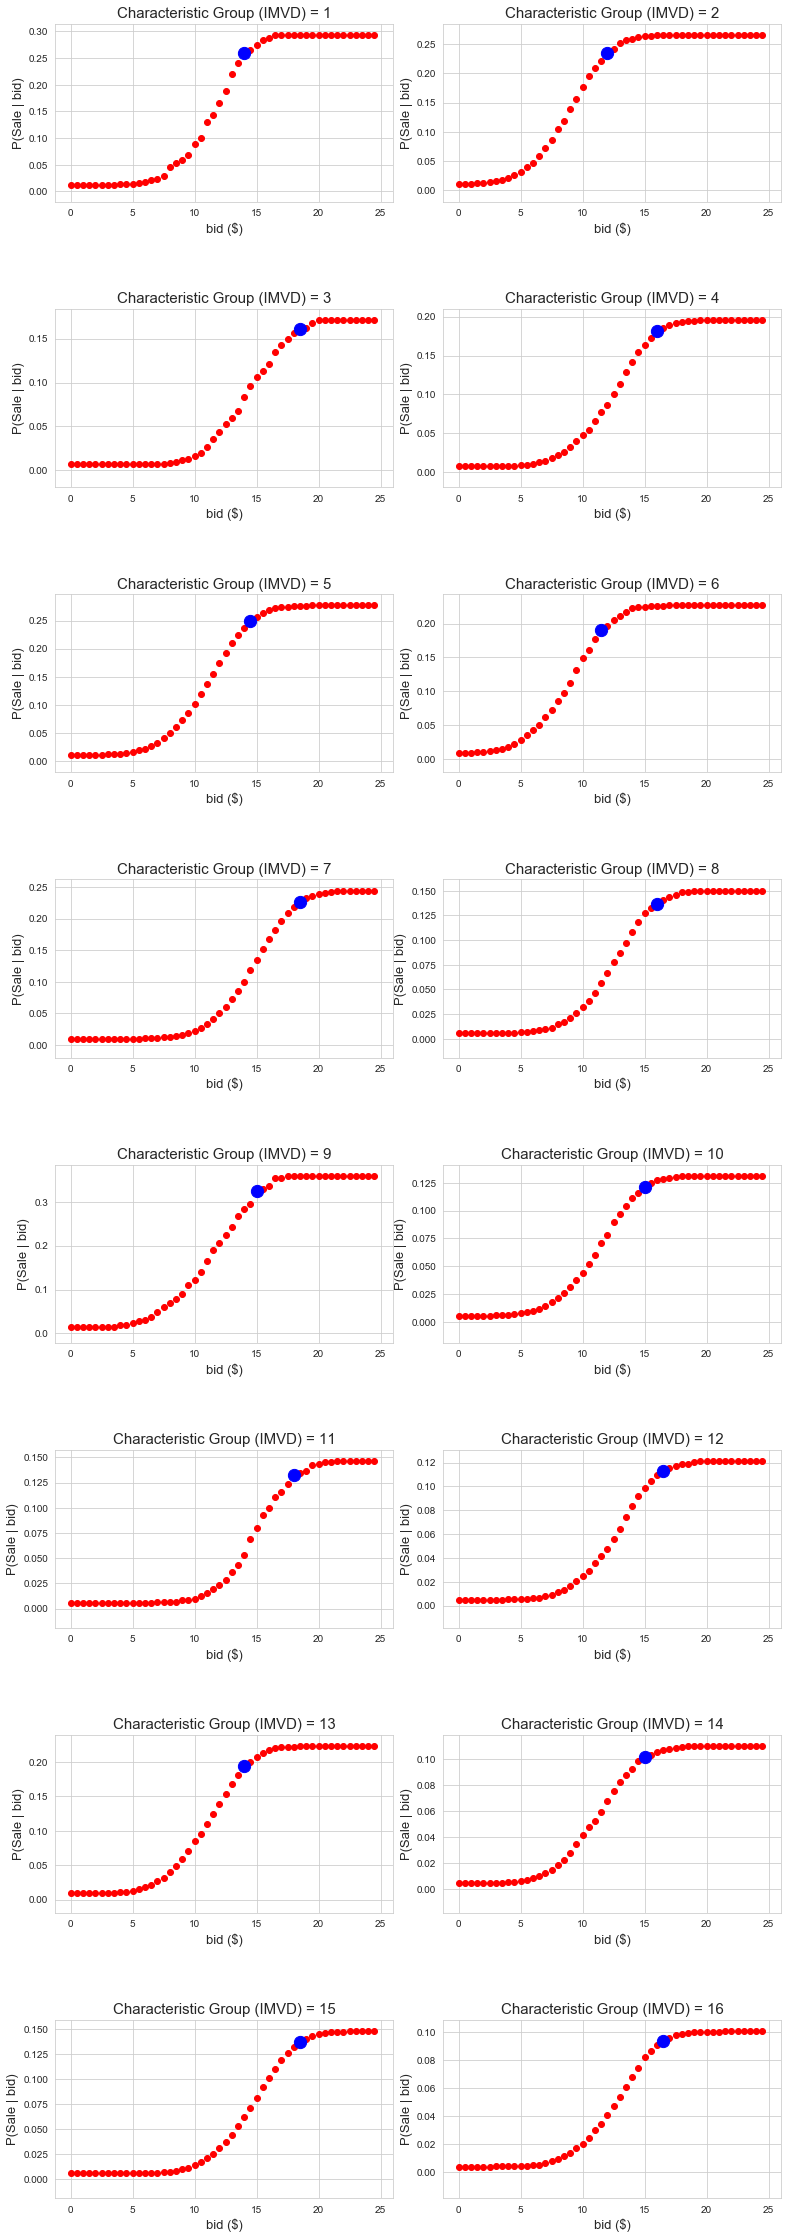

In [15]:
#Now let's create new ranks based on different bids for each group and find new histograms
opt_cutoff = 0.004 #optimization cutoff - marginal benefit
rnks = np.zeros([16,5]) #freq(rank_i|price)
rnks_prob = np.zeros([16,5]) #P(rank_i|price)
targets0 = np.zeros([16,5])
bidOpt = np.zeros([16])
Expected_val = np.zeros([16])
slope_max = np.zeros([16])
#Expected_val_lastbid = np.zeros([16])

fig, ax3 = plt.subplots(8,2, figsize=(13, 40), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace= .15)
ax3 = ax3.ravel()

Exp_bid = np.zeros([16,81]) # Exp_val for every bid
d_bid = 0.5
for IMVD in range(1,17):
    Expected_val_lastbid = 0
    #print(IMVD)
    for bid0 in range(1,51):
        bid1 = (bid0-1)*d_bid
        acmeS['bids'] = np.ones(len(acmeS['cost']))*bid1
        acmeS['NewRank'] = np.ones(len(acmeS['rank']))
        r1 = (acmeS['bids'] < acmeS['Comp1'])*1
        r2 = (acmeS['bids'] < acmeS['Comp2'])*1
        r3 = (acmeS['bids'] < acmeS['Comp3'])*1
        r4 = (acmeS['bids'] < acmeS['Comp4'])*1
        acmeS['NewRank'] = r1+r2+r3+r4+1
        
        for rnk in range(1,6):
            rnks[IMVD-1][rnk-1] = len(acmeS['NewRank'].loc[acmeS['NewRank'] == rnk].loc[acmeS['IMVD_Indicator_1_16'] == IMVD])
            rnks_prob[IMVD-1][rnk-1] = rnks[IMVD-1][rnk-1] / len(acmeS['NewRank'].loc[acmeS['IMVD_Indicator_1_16'] == IMVD])
            #we use the previous cell - not the following two lines.
            #Pclk_rnk[IMVD-1][rnk-1] = np.mean(acmeS['click'].loc[acmeS['NewRank'] == rnk].loc[acmeS['IMVD_Indicator_1_16'] == IMVD])
            #Pbuy_clk[IMVD-1][rnk-1] = np.mean(acmeS['policies sold'].loc[acmeS['NewRank'] == rnk].loc[acmeS['click'] == 1].loc[acmeS['IMVD_Indicator_1_16'] == IMVD])
            
            targets0[IMVD-1][rnk-1] = rnks_prob[IMVD-1][rnk-1]*Pclk_rnk[rnk-1]*Pbuy_clk[IMVD-1]
            nan_ind = np.isnan(targets0)
            targets0[nan_ind]=0.0
            
        opt_cutoff00 = opt_cutoff
        if IMVD in [3,4,7,8,11,12,15,16]: #two vehicle groups
            opt_cutoff00 = opt_cutoff/2
            
        if bid0==1:
            Expected_val[IMVD-1] = np.sum(targets0,1)[IMVD-1]
            Expected_val_lastbid = np.sum(targets0,1)[IMVD-1]
            bidOpt[IMVD-1] = bid1
        else:
            #if (np.sum(targets0,1)[IMVD-1] > Expected_val_lastbid + opt_cutoff00*d_bid):
            #if (np.sum(targets0,1)[IMVD-1]/bid1 > Expected_val_lastbid/(bid1-d_bid)):
            slope = Expected_val[IMVD-1]/bidOpt[IMVD-1]
            if bid0 in [1,2,3,4,5,6,7,8]: slope = 0
            if (np.sum(targets0,1)[IMVD-1]/bid1 > slope):
                bidOpt[IMVD-1] = bid1
                Expected_val[IMVD-1] = np.sum(targets0,1)[IMVD-1]
                slope_max[IMVD-1] = np.sum(targets0,1)[IMVD-1]/bid1
                
        Expected_val_lastbid = np.sum(targets0,1)[IMVD-1]
        
        #if IMVD in [3,4,7,8,11,12,15,16]:
        #    np.sum(targets0,1)[IMVD-1] = np.sum(targets0,1)[IMVD-1]*2
        ax3[IMVD-1].scatter(bid1,np.sum(targets0,1)[IMVD-1],color = 'r')
        ax3[IMVD-1].set_xlabel('bid ($)',fontsize = 13)
        ax3[IMVD-1].set_ylabel('P(Sale | bid)',fontsize=13)
        ax3[IMVD-1].set_title('Characteristic Group (IMVD) = ' + str(IMVD), fontsize = 15)
        Exp_bid[IMVD-1][bid0-1] = np.sum(targets0,1)[IMVD-1]

for IMVD in range(1,17):
    ax3[IMVD-1].scatter(bidOpt[IMVD-1],Expected_val[IMVD-1],color = 'b' , s = 150)


## We Found Optimal Bids!
Each scatter plot shows the relationship between bids and Sale likelihood for different characteristic groups. Also marked by blue dots in scatter plots are the unconstrained optimal bid value for each group.

## Let's compare our proposed bids with status quo

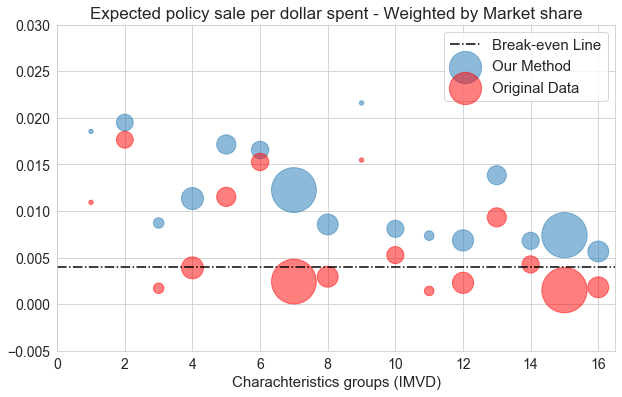

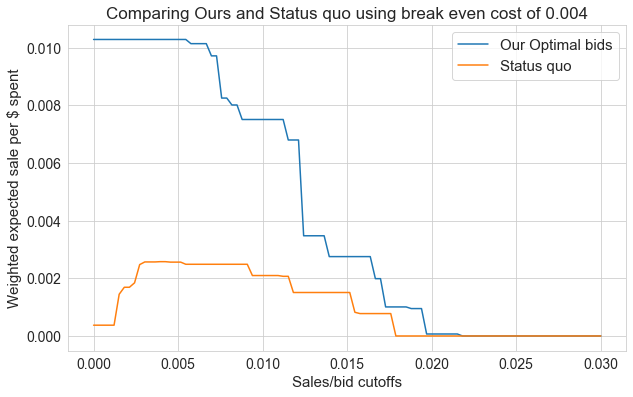

In [19]:
slope_old = Exp_vals/10
mkt_share = np.zeros([16])
for IMVD in range(1,17):
    mkt_share[IMVD-1] = len(acmeS['IMVD_Indicator_1_16'].loc[acmeS['IMVD_Indicator_1_16']==IMVD])/10000
for IMVD in [3,4,7,8,11,12,15,16]:
#    slope_old[IMVD-1] = slope_old[IMVD-1]*2
#    slope_max[IMVD-1] = slope_max[IMVD-1]*2
    mkt_share[IMVD-1] = mkt_share[IMVD-1]*2
#mkt_share = mkt_share/np.sum(mkt_share)
#    slope_max[IMVD-1] = slope_max[IMVD-1]*2
#    slope_old[IMVD-1] = slope_old[IMVD-1]*2
plt.figure(figsize = (10,6))
plt.scatter(range(1,17),slope_max , s = mkt_share*5000 , alpha = .5 , label = 'Our Method')
plt.scatter(range(1,17),slope_old , color = 'r',s = mkt_share*5000 , alpha = .5 , label = 'Original Data' )
plt.ylim(-.005,.03)
plt.xlim(0,16.5)
plt.plot([0,16.5],[.004,.004],'-.',c='k', label = 'Break-even Line')
plt.title('Expected policy sale per dollar spent - Weighted by Market share' , fontsize = 17)
plt.legend(fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Charachteristics groups (IMVD)',fontsize = 15)

plt.show()

prod1 = (slope_max - .004)*mkt_share
prod2 = (slope_old - .004)*mkt_share
MargRevenueOurs = np.zeros(100)
MargRevenueStQuo = np.zeros(100)
ic = 0
for cutf in np.linspace(0,.03,100):
    MargRevenueOurs[ic] = np.sum(prod1*(slope_max>cutf)) #Marginal revenue (sale cutoff): liklihood of policy sale * Market share per dollar spent
    MargRevenueStQuo[ic] = np.sum(prod2*(slope_old>cutf)) 
    ic = ic + 1

plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,.03,100) , MargRevenueOurs , label = 'Our Optimal bids')
plt.plot(np.linspace(0,.03,100) , MargRevenueStQuo , label = 'Status quo')
plt.title('Comparing Ours and Status quo using break even cost of 0.004', fontsize = 17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sales/bid cutoffs',fontsize = 15)
plt.ylabel('Weighted expected sale per $ spent',fontsize = 15)
plt.legend(fontsize=15)
plt.show()


In [20]:
print('Optimal bids for different groups : ', bidOpt)
print()
WtdAvgOur = np.round(np.sum(slope_max*mkt_share) , 5)#-.004
WtdAvgOrig = np.round(np.sum(slope_old*mkt_share) , 5)#-.004
print('Our Policies Sold per 10,000 : ' , WtdAvgOur*10000 , 
      '.... Status quo Policies Sold per 10,000 : ' , WtdAvgOrig*10000 ,
      '.... Increase? : ' , np.round((WtdAvgOur-WtdAvgOrig)/WtdAvgOrig*100,1) , '%')

Optimal bids for different groups :  [14.  12.  18.5 16.  14.5 11.5 18.5 16.  15.  15.  18.  16.5 14.  15.
 18.5 16.5]

Our Policies Sold per 10,000 :  167.1 .... Status quo Policies Sold per 10,000 :  68.1 .... Increase? :  145.4 %


## End of analysis